In [2]:
import pandas as pd
import numpy as np
import os
from dask import dataframe as dd
import time


### STITCH data
Al **.v5.0.tsv* files were downloaded from STITCH database (website). 

*chemical_chemical.links.detailed.v5.0.tsv* contains a list of connected metabolites with an edge score.

*chemicals.inchikeys.v5.0.tsv* contains InChIKeys for STITCH compounds 

*chemical.sources.v5.0.tsv* contains chemical IDs based on other databases. It was filtered for  KEGG, ChEBI, Pubmed CID, Pubmed SID.

*chemical.aliases.v5.0.tsv* contains chemical synonyms for STITCH compounds, based on chemical name and/or other databases. It was filtered for  KEGG and ChEBI.

awk -F'\t' 'NR==1 || $4 == "KEGG" || $4 == "ChEBI" ' chemical.aliases.v5.0.tsv > chemical.aliases.filtered.tsv
awk -F'\t' 'NR==1 || $3 == "KEGG"' chemical.sources.filtered.tsv > chemical.sources.filtered.KEGG.tsv
awk -F'\t' 'NR==1 || $3 == "ChEBI"' chemical.sources.filtered.tsv > chemical.sources.filtered.ChEBI.tsv

In [4]:
stitch_links = pd.read_csv("../data/STITCH/chemical_chemical.links.detailed.v5.0.tsv", sep="\t")
stitch_links

,chemical1,chemical2,similarity,experimental,database,textmining,combined_score
0,CIDm00024759,CIDs00024759,0,0,900,0,900
1,CIDs91758695,CIDs00107694,0,0,0,230,230
2,CIDs91758695,CIDs11013287,0,0,0,230,230
3,CIDs91758695,CIDs11980957,0,0,0,328,328
4,CIDs91758695,CIDs00013078,0,0,0,162,162
...,...,...,...,...,...,...,...
17705813,CIDm00000001,CIDm87081431,753,0,0,173,173
17705814,CIDm00000001,CIDm90857042,0,0,0,218,218
17705815,CIDm00000001,CIDm91056687,0,0,0,294,294
17705816,CIDm00000001,CIDm91213096,0,0,0,357,357


In [5]:
stitch_links = stitch_links[['chemical1', 'chemical2', 'combined_score']]
stitch_links.drop_duplicates(inplace=True)
stitch_links

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,chemical1,chemical2,combined_score
0,CIDm00024759,CIDs00024759,900
1,CIDs91758695,CIDs00107694,230
2,CIDs91758695,CIDs11013287,230
3,CIDs91758695,CIDs11980957,328
4,CIDs91758695,CIDs00013078,162
...,...,...,...
17705812,CIDm00000001,CIDm87076413,176
17705813,CIDm00000001,CIDm87081431,173
17705814,CIDm00000001,CIDm90857042,218
17705815,CIDm00000001,CIDm91056687,294


In [6]:
stitch_links.duplicated(subset = ['chemical1', 'chemical2', 'combined_score']).any()

False

In [7]:
# Prune the network to get only edges with medium confidence score
min_score = 700 # Minimum confidence score to keep an edge
n = stitch_links.shape[0]
stitch_links = stitch_links.loc[stitch_links['combined_score']>= min_score]
nf = stitch_links.shape[0]
print("Metabolite-Metabolite edges included: " + str(nf) + "/" + str(n) + " (" + str(round(nf/n * 100, 2))+ " %)")

Metabolite-Metabolite edges included: 891490/17705799 (5.04 %)


In [8]:
print(stitch_links.shape)
print(len(stitch_links.chemical1.unique()))

(891490, 3)
229806


### Add Pubchem IDs

In [7]:
for chemical in ["chemical1", "chemical2"]:
    met = stitch_links.loc[:,chemical].str.extract(r'(CIDs|CIDm)0*([1-9]\d*)')
    met.columns = ['stero/flat', 'CID']
    stitch_links[chemical+'_PUBCHEM'] = met['CID']
    stitch_links[chemical+'_PUBCHEM'] = stitch_links[chemical+'_PUBCHEM'].astype(float)
stitch_links

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0
5,CIDs91758695,CIDs00013109,468,91758695.0,13109.0
7,CIDs91758695,CIDs00024706,452,91758695.0,24706.0
9,CIDs91758695,CIDs00040973,505,91758695.0,40973.0
12,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0
...,...,...,...,...,...
17705746,CIDm00000001,CIDm05460048,549,1.0,5460048.0
17705749,CIDm00000001,CIDm05493381,527,1.0,5493381.0
17705751,CIDm00000001,CIDm06426901,444,1.0,6426901.0
17705785,CIDm00000001,CIDm25271602,900,1.0,25271602.0


In [8]:
stitch_links['chemical1_PUBCHEM'].to_csv("stitch_links_chemical1_PUBCHEM_400.csv")
stitch_links['chemical2_PUBCHEM'].to_csv("stitch_links_chemical2_PUBCHEM_400.csv")

### Add inchikeys IDs

In [9]:
# retrieve pubchem id
inchikeys_file = "../data/STITCH/chemicals.inchikeys.v5.0.tsv"

#sources_file = "../data/chemical.sources.v5.0.sourcefiltered_format.tsv"
start_time = time.time()
df_inchikeys = dd.read_csv(inchikeys_file, sep='\t', low_memory=False)
inchi_data=df_inchikeys.compute() # takes a while
end_time = time.time()
print('Time taken to open file:', end_time - start_time, 'seconds')

Time taken to open file: 317.7916362285614 seconds


In [10]:
inchi_data

,flat_chemical_id,stereo_chemical_id,source_cid,inchikey
0,CIDm00000001,CIDs00000001,1,RDHQFKQIGNGIED-UHFFFAOYSA-N
1,CIDm00000010,CIDs00000010,10,AUFGTPPARQZWDO-UHFFFAOYSA-N
2,CIDm00000100,CIDs00000100,100,UTIBHEBNILDQKX-UHFFFAOYSA-N
3,CIDm00001000,CIDs00001000,1000,ULSIYEODSMZIPX-UHFFFAOYSA-N
4,CIDm00010000,CIDs00010000,10000,ZPIFKCVYZBVZIV-UHFFFAOYSA-N
...,...,...,...,...
159686,CIDm09999995,CIDs09999995,9999995,XPKJPIMTEFXWTR-QJSROADHSA-N
159687,CIDm09999996,CIDs09999996,9999996,UIACKXKZPDPMBY-UHFFFAOYSA-N
159688,CIDm09999996,CIDs09999996,9999997,PLLYNUUCBINGLY-UHFFFAOYSA-N
159689,CIDm09999998,CIDs09999998,9999998,PFFVTWFOPAQBJU-UHFFFAOYSA-N


In [11]:
inchi_data.duplicated().any()

False

In [12]:
inchi_data['source_cid'] = inchi_data['source_cid'].astype(float)


In [13]:
# merge on chemical1
stitch_links = stitch_links.merge(inchi_data[['source_cid', "inchikey"]], left_on='chemical1_PUBCHEM', right_on='source_cid', how='left')
stitch_links.drop('source_cid', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,inchikey
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N
...,...,...,...,...,...,...
3307115,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N
3307116,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N
3307117,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N
3307118,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N


In [14]:
# merge on chemical2
stitch_links = stitch_links.merge(inchi_data[['source_cid', "inchikey"]], left_on='chemical2_PUBCHEM', right_on='source_cid', how='left')
stitch_links.drop('source_cid', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,inchikey_x,inchikey_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3307115,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N
3307116,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N
3307117,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N
3307118,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [15]:
stitch_links = stitch_links.rename(columns={'inchikey_x': 'chemical1_inchikey', 'inchikey_y': 'chemical2_inchikey'})
stitch_links.drop_duplicates(inplace=True)
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3307115,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N
3307116,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N
3307117,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N
3307118,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [16]:
# saving point
stitch_links.to_csv("../data/STITCH/stitch_links_pubchem_inchikeys_400.csv", index=False)

### Add KEGG IDs

In [42]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_pubchem_inchikeys_400.csv")
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3307115,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N
3307116,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N
3307117,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N
3307118,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [18]:
# retrieve KEGG id
sources_file = "../data/STITCH/chemical.sources.filtered.KEGG.tsv"

#sources_file = "../data/chemical.sources.filtered.tsv"
start_time = time.time()
df_sources = dd.read_csv(sources_file, sep='\t', low_memory=False, names=["chemical_CIDm", "chemical_CIDs", "source", "alias"])
sources_data_kegg=df_sources.compute(scheduler='threads') # takes a while
end_time = time.time()
print('Time taken to open file:', end_time - start_time, 'seconds')

Time taken to open file: 0.2327899932861328 seconds


In [43]:
sources_data_kegg

,chemical_CIDm,chemical_CIDs,source,alias
1,CIDm00000961,CIDs00000961,KEGG,C00001
2,CIDm00000238,CIDs00005957,KEGG,C00002
3,CIDm00000925,CIDs00005892,KEGG,C00003
4,CIDm00000928,CIDs00439153,KEGG,C00004
5,CIDm00000930,CIDs00005884,KEGG,C00005
...,...,...,...,...
15316,CIDm44224057,CIDs44224057,KEGG,C20697
15317,CIDm00001598,CIDs00001598,KEGG,C20698
15318,CIDm71464585,CIDs71464585,KEGG,C20699
15319,CIDm00188440,CIDs06443227,KEGG,C20700


In [20]:
sources_data_kegg = sources_data_kegg.iloc[1:,:]
sources_data_kegg

,chemical_CIDm,chemical_CIDs,source,alias
1,CIDm00000961,CIDs00000961,KEGG,C00001
2,CIDm00000238,CIDs00005957,KEGG,C00002
3,CIDm00000925,CIDs00005892,KEGG,C00003
4,CIDm00000928,CIDs00439153,KEGG,C00004
5,CIDm00000930,CIDs00005884,KEGG,C00005
...,...,...,...,...
22962,CIDm16132139,CIDs16197727,KEGG,D10511
22963,CIDm11511120,CIDs11511120,KEGG,D10514
22964,CIDm00068740,CIDs00068740,KEGG,D10515
22965,CIDm00060795,CIDs00060795,KEGG,D10516


In [21]:
# use only KEGG compounds, which start with C
sources_data_kegg = sources_data_kegg.loc[sources_data_kegg['alias'].str.startswith('C')]
sources_data_kegg

,chemical_CIDm,chemical_CIDs,source,alias
1,CIDm00000961,CIDs00000961,KEGG,C00001
2,CIDm00000238,CIDs00005957,KEGG,C00002
3,CIDm00000925,CIDs00005892,KEGG,C00003
4,CIDm00000928,CIDs00439153,KEGG,C00004
5,CIDm00000930,CIDs00005884,KEGG,C00005
...,...,...,...,...
15316,CIDm44224057,CIDs44224057,KEGG,C20697
15317,CIDm00001598,CIDs00001598,KEGG,C20698
15318,CIDm71464585,CIDs71464585,KEGG,C20699
15319,CIDm00188440,CIDs06443227,KEGG,C20700


In [44]:
# merge on flat_chemicals for chemical1
stitch_links = stitch_links.merge(sources_data_kegg[['chemical_CIDm', "alias"]], left_on='chemical1', right_on='chemical_CIDm', how='left')
stitch_links.drop('chemical_CIDm', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN
...,...,...,...,...,...,...,...,...
3441893,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571
3441894,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571
3441895,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571
3441896,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571


In [45]:
# merge on stereo_chemicals for chemical1
stitch_links = stitch_links.merge(sources_data_kegg[['chemical_CIDs', "alias"]], left_on='chemical1', right_on='chemical_CIDs', how='left')
stitch_links.drop('chemical_CIDs', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3487041,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN
3487042,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN
3487043,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN
3487044,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


In [46]:
# Use fillna to fill missing values in Pubchem_CIDs_df1 with values from Pubchem_CIDs_df2
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
# Drop the redundant Pubchem_CIDs_df2 column and rename column _df1
stitch_links = stitch_links.drop(columns=['alias_y'])
stitch_links = stitch_links.rename(columns={'alias_x': 'chemical1_KEGG'})
stitch_links.drop_duplicates()

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN
...,...,...,...,...,...,...,...,...
3487041,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571
3487042,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571
3487043,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571
3487044,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571


In [47]:
# merge on flat_chemicals for chemical2
stitch_links = stitch_links.merge(sources_data_kegg[['chemical_CIDm', "alias"]], left_on='chemical2', right_on='chemical_CIDm', how='left')
stitch_links.drop('chemical_CIDm', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3677171,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN
3677172,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN
3677173,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN
3677174,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


In [48]:
# merge on stereo_chemicals for chemical2
stitch_links = stitch_links.merge(sources_data_kegg[['chemical_CIDs', "alias"]], left_on='chemical2', right_on='chemical_CIDs', how='left')
stitch_links.drop('chemical_CIDs', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,NaN,C08149
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,NaN,C08153
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,NaN,C07629
...,...,...,...,...,...,...,...,...,...,...
3726141,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN,NaN
3726142,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN,NaN
3726143,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN,NaN
3726144,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN,NaN


In [49]:
# Use fillna to fill missing values in Pubchem_CIDs_df1 with values from Pubchem_CIDs_df2
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
# Drop the redundant Pubchem_CIDs_df2 column and rename column _df1
stitch_links = stitch_links.drop(columns=['alias_y'])
stitch_links = stitch_links.rename(columns={'alias_x': 'chemical2_KEGG'})
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629
...,...,...,...,...,...,...,...,...,...
3726141,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN
3726142,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN
3726143,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN
3726144,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


#### Retrieve kegg ids from aliases file

In [28]:
# retrieve KEGG id
aliases_file = "../data/STITCH/chemical.aliases.filtered.tsv"

#sources_file = "../data/chemical.sources.filtered.tsv"
start_time = time.time()
df_aliases = dd.read_csv(aliases_file, sep='\t', low_memory=False)
aliases_data=df_aliases.compute(scheduler='threads') # takes a while
end_time = time.time()
print('Time taken to open file:', end_time - start_time, 'seconds')

Time taken to open file: 0.18066191673278809 seconds


In [30]:
aliases_data

,flat_chemical,stereo_chemical,alias,source
0,CIDm00000001,CIDs00000001,3-(acetyloxy)-4-(trimethylammonio)butanoate,ChEBI
1,CIDm00000001,CIDs00000001,3-(acetyloxy)-4-(trimethylazaniumyl)butanoate,ChEBI
2,CIDm00000001,CIDs00000001,CHEBI:73024,ChEBI
3,CIDm00000001,CIDs00439756,O-acetyl-(R)-carnitine,ChEBI
4,CIDm00000003,CIDs24771801,CHEBI:48969,ChEBI
...,...,...,...,...
92811,CIDm91666443,CIDs91666443,CHEBI:85108,ChEBI
92812,CIDm91666445,CIDs91666445,"7,8-dihydroxanthopterin",ChEBI
92813,CIDm91666445,CIDs91666445,CHEBI:85130,ChEBI
92814,CIDm91666454,CIDs91666454,2-glyceryl-prostaglandin G2,ChEBI


In [31]:
aliases_kegg = aliases_data.loc[aliases_data['source']=='KEGG']
aliases_kegg

,flat_chemical,stereo_chemical,alias,source
7,CIDm00000003,CIDs09964159,"(2S,3S)-2,3-Dihydro-2,3-dihydroxybenzoate",KEGG
10,CIDm00000004,CIDs00000004,C05771,KEGG
15,CIDm00000004,CIDs00439938,C03194,KEGG
21,CIDm00000006,CIDs00000006,C14397,KEGG
25,CIDm00000008,CIDs00448154,C06007,KEGG
...,...,...,...,...
91315,CIDm72734356,CIDs72734356,Cabazitaxel acetonate (JAN),KEGG
91316,CIDm72734356,CIDs72734356,D10452,KEGG
91317,CIDm72734359,CIDs72734359,479410-20-3,KEGG
91318,CIDm72734359,CIDs72734359,D10491,KEGG


In [50]:
# use only KEGG compounds, which start with C
aliases_kegg = aliases_kegg[aliases_kegg['alias'].str.match(r'C\d{5}')]
aliases_kegg

,flat_chemical,stereo_chemical,alias,source
10,CIDm00000004,CIDs00000004,C05771,KEGG
15,CIDm00000004,CIDs00439938,C03194,KEGG
21,CIDm00000006,CIDs00000006,C14397,KEGG
25,CIDm00000008,CIDs00448154,C06007,KEGG
28,CIDm00000008,CIDs00000008,C04104,KEGG
...,...,...,...,...
91293,CIDm72734298,CIDs72734298,C20529,KEGG
91295,CIDm72734299,CIDs72734299,C20532,KEGG
91296,CIDm72734301,CIDs72734301,C20535,KEGG
91297,CIDm72734301,CIDs72734306,C20558,KEGG


In [51]:
# merge on flat_chemicals for chemical1
stitch_links = stitch_links.merge(aliases_kegg[['flat_chemical', "alias"]], left_on='chemical1', right_on='flat_chemical', how='left')
stitch_links.drop('flat_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149,NaN
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153,NaN
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629,NaN
...,...,...,...,...,...,...,...,...,...,...
4660061,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN,NaN
4660062,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN,NaN
4660063,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN,NaN
4660064,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN,NaN


In [52]:
# merge on stereo_chemicals for chemical1
stitch_links = stitch_links.merge(aliases_kegg[['stereo_chemical', "alias"]], left_on='chemical1', right_on='stereo_chemical', how='left')
stitch_links.drop('stereo_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149,NaN,NaN
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153,NaN,NaN
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4763267,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN,NaN,NaN
4763268,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN,NaN,NaN
4763269,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN,NaN,NaN
4763270,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN,NaN,NaN


In [53]:
# Use fillna to fill missing values in alias_x with values from alias_y
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
stitch_links = stitch_links.drop(columns=['alias_y'])
# Use fillna to fill missing values in chemical1_KEGG with values from alias_x
stitch_links['chemical1_KEGG'] = stitch_links['chemical1_KEGG'].fillna(stitch_links['alias_x'])
stitch_links = stitch_links.drop(columns=['alias_x'])
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629
...,...,...,...,...,...,...,...,...,...
4763267,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN
4763268,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN
4763269,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN
4763270,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


In [55]:
# merge on flat_chemicals for chemical2
stitch_links = stitch_links.merge(aliases_kegg[['flat_chemical', "alias"]], left_on='chemical2', right_on='flat_chemical', how='left')
stitch_links.drop('flat_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149,NaN
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153,NaN
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629,NaN
...,...,...,...,...,...,...,...,...,...,...
7308465,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN,NaN
7308466,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN,NaN
7308467,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN,NaN
7308468,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN,NaN


In [56]:
# merge on stereo_chemicals for chemical2
stitch_links = stitch_links.merge(aliases_kegg[['stereo_chemical', "alias"]], left_on='chemical2', right_on='stereo_chemical', how='left')
stitch_links.drop('stereo_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149,NaN,NaN
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153,NaN,NaN
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4763267,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN,NaN,NaN
4763268,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN,NaN,NaN
4763269,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN,NaN,NaN
4763270,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN,NaN,NaN


In [57]:
# Use fillna to fill missing values in alias_x with values from alias_y
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
stitch_links = stitch_links.drop(columns=['alias_y'])
# Use fillna to fill missing values in chemical1_KEGG with values from alias_x
stitch_links['chemical2_KEGG'] = stitch_links['chemical2_KEGG'].fillna(stitch_links['alias_x'])
stitch_links = stitch_links.drop(columns=['alias_x'])
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629
...,...,...,...,...,...,...,...,...,...
4763267,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN
4763268,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN
4763269,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN
4763270,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


In [58]:
# saving point
stitch_links.to_csv("../data/STITCH/stitch_links_pubchem_inchikeys_kegg_400.csv", index=False)

### Add CHEBI IDs

In [2]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_pubchem_inchikeys_kegg_400.csv")
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08149
2,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,WWYNJERNGUHSAO-XUDSTZEESA-N,NaN,C08153
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ORKBYCQJWQBPFG-WOMZHKBXSA-N,NaN,NaN
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,RPLCPCMSCLEKRS-BPIQYHPVSA-N,NaN,C07629
...,...,...,...,...,...,...,...,...,...
4763267,CIDm00000001,CIDm05460048,549,1.0,5460048.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFTFJSFQGQCHQW-UHFFFAOYSA-N,C02571,NaN
4763268,CIDm00000001,CIDm05493381,527,1.0,5493381.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,FMSOAWSKCWYLBB-VBGLAJCLSA-N,C02571,NaN
4763269,CIDm00000001,CIDm06426901,444,1.0,6426901.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,IHCPDBBYTYJYIL-UHFFFAOYSA-N,C02571,NaN
4763270,CIDm00000001,CIDm25271602,900,1.0,25271602.0,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


Because the tables are very large, chebi annotation will go to a different file, with only STITCH chemical names, pubchem, and chebi.

In [3]:
stitch_links = stitch_links[['chemical1', 'chemical2', 'combined_score', 'chemical1_PUBCHEM', 'chemical2_PUBCHEM']]
stitch_links.drop_duplicates(inplace=True)
stitch_links

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0
3,CIDs91758695,CIDs00024706,452,91758695.0,24706.0
4,CIDs91758695,CIDs00040973,505,91758695.0,40973.0
5,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0
...,...,...,...,...,...
4763267,CIDm00000001,CIDm05460048,549,1.0,5460048.0
4763268,CIDm00000001,CIDm05493381,527,1.0,5493381.0
4763269,CIDm00000001,CIDm06426901,444,1.0,6426901.0
4763270,CIDm00000001,CIDm25271602,900,1.0,25271602.0


In [4]:
# retrieve KEGG id
sources_file = "../data/STITCH/chemical.sources.filtered.ChEBI.tsv"

#sources_file = "../data/chemical.sources.filtered.tsv"
start_time = time.time()
df_sources = dd.read_csv(sources_file, sep='\t', low_memory=False, names=["chemical_CIDm", "chemical_CIDs", "source", "alias"])
sources_data_chebi=df_sources.compute(scheduler='threads') # takes a while
end_time = time.time()
print('Time taken to open file:', end_time - start_time, 'seconds')
sources_data_chebi

Time taken to open file: 0.13098978996276855 seconds


,chemical_CIDm,chemical_CIDs,source,alias
0,chemical,alias,source,NaN
1,CIDm00098409,CIDs00177154,ChEBI,CHEBI:10
2,CIDm00073067,CIDs00336327,ChEBI,CHEBI:100
3,CIDm00354179,CIDs05281573,ChEBI,CHEBI:10000
4,CIDm00010157,CIDs00442151,ChEBI,CHEBI:10001
...,...,...,...,...
41431,CIDm00005668,CIDs00015376,ChEBI,CHEBI:9985
41432,CIDm00442665,CIDs00442665,ChEBI,CHEBI:9992
41433,CIDm00441955,CIDs00441955,ChEBI,CHEBI:9996
41434,CIDm00005674,CIDs05459319,ChEBI,CHEBI:9997


In [5]:
sources_data_chebi = sources_data_chebi.iloc[1:,:]
sources_data_chebi['alias'] = sources_data_chebi['alias'].str.replace(r'^CHEBI:', '')
sources_data_chebi['alias'] = sources_data_chebi['alias'].astype(float)
sources_data_chebi

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,chemical_CIDm,chemical_CIDs,source,alias
1,CIDm00098409,CIDs00177154,ChEBI,10.0
2,CIDm00073067,CIDs00336327,ChEBI,100.0
3,CIDm00354179,CIDs05281573,ChEBI,10000.0
4,CIDm00010157,CIDs00442151,ChEBI,10001.0
5,CIDm00006716,CIDs00006716,ChEBI,10002.0
...,...,...,...,...
41431,CIDm00005668,CIDs00015376,ChEBI,9985.0
41432,CIDm00442665,CIDs00442665,ChEBI,9992.0
41433,CIDm00441955,CIDs00441955,ChEBI,9996.0
41434,CIDm00005674,CIDs05459319,ChEBI,9997.0


In [6]:
# merge on flat_chemicals for chemical1
stitch_links = stitch_links.merge(sources_data_chebi[['chemical_CIDm', "alias"]], left_on='chemical1', right_on='chemical_CIDm', how='left')
stitch_links.drop('chemical_CIDm', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN
...,...,...,...,...,...,...
4265541,CIDm00000001,CIDm25271602,900,1.0,25271602.0,57589.0
4265542,CIDm00000001,CIDm25271602,900,1.0,25271602.0,73024.0
4265543,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0
4265544,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0


In [7]:
# merge on stereo_chemicals for chemical1
stitch_links = stitch_links.merge(sources_data_chebi[['chemical_CIDs', "alias"]], left_on='chemical1', right_on='chemical_CIDs', how='left')
stitch_links.drop('chemical_CIDs', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
4819563,CIDm00000001,CIDm25271602,900,1.0,25271602.0,57589.0,NaN
4819564,CIDm00000001,CIDm25271602,900,1.0,25271602.0,73024.0,NaN
4819565,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,NaN
4819566,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,NaN


In [8]:
# Use fillna to fill missing values in Pubchem_CIDs_df1 with values from Pubchem_CIDs_df2
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
# Drop the redundant Pubchem_CIDs_df2 column and rename column _df1
stitch_links = stitch_links.drop(columns=['alias_y'])
stitch_links = stitch_links.rename(columns={'alias_x': 'chemical1_ChEBI'})
stitch_links.drop_duplicates()

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN
...,...,...,...,...,...,...
4819563,CIDm00000001,CIDm25271602,900,1.0,25271602.0,57589.0
4819564,CIDm00000001,CIDm25271602,900,1.0,25271602.0,73024.0
4819565,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0
4819566,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0


In [9]:
# merge on flat_chemicals for chemical2
stitch_links = stitch_links.merge(sources_data_chebi[['chemical_CIDm', "alias"]], left_on='chemical2', right_on='chemical_CIDm', how='left')
stitch_links.drop('chemical_CIDm', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
7787145,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0
7787146,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0
7787147,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0
7787148,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0


In [10]:
# merge on stereo_chemicals for chemical2
stitch_links = stitch_links.merge(sources_data_chebi[['chemical_CIDs', "alias"]], left_on='chemical2', right_on='chemical_CIDs', how='left')
stitch_links.drop('chemical_CIDs', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,NaN,6443.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,NaN,4453.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8881367,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN
8881368,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN
8881369,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN
8881370,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN


In [11]:
# Use fillna to fill missing values in Pubchem_CIDs_df1 with values from Pubchem_CIDs_df2
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
# Drop the redundant Pubchem_CIDs_df2 column and rename column _df1
stitch_links = stitch_links.drop(columns=['alias_y'])
stitch_links = stitch_links.rename(columns={'alias_x': 'chemical2_ChEBI'})
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
8881367,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0
8881368,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0
8881369,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0
8881370,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0


#### Retrieve ChEBI ids from aliases file


In [12]:
# retrieve KEGG id
aliases_file = "../data/STITCH/chemical.aliases.filtered.tsv"

#sources_file = "../data/chemical.sources.filtered.tsv"
start_time = time.time()
df_aliases = dd.read_csv(aliases_file, sep='\t', low_memory=False)
aliases_data=df_aliases.compute(scheduler='threads') # takes a while
end_time = time.time()
print('Time taken to open file:', end_time - start_time, 'seconds')

Time taken to open file: 0.23496389389038086 seconds


In [14]:
aliases_data

,flat_chemical,stereo_chemical,alias,source
0,CIDm00000001,CIDs00000001,3-(acetyloxy)-4-(trimethylammonio)butanoate,ChEBI
1,CIDm00000001,CIDs00000001,3-(acetyloxy)-4-(trimethylazaniumyl)butanoate,ChEBI
2,CIDm00000001,CIDs00000001,CHEBI:73024,ChEBI
3,CIDm00000001,CIDs00439756,O-acetyl-(R)-carnitine,ChEBI
4,CIDm00000003,CIDs24771801,CHEBI:48969,ChEBI
...,...,...,...,...
92811,CIDm91666443,CIDs91666443,CHEBI:85108,ChEBI
92812,CIDm91666445,CIDs91666445,"7,8-dihydroxanthopterin",ChEBI
92813,CIDm91666445,CIDs91666445,CHEBI:85130,ChEBI
92814,CIDm91666454,CIDs91666454,2-glyceryl-prostaglandin G2,ChEBI


In [15]:
aliases_chebi = aliases_data.loc[aliases_data['source']=='ChEBI']
aliases_chebi = aliases_chebi[aliases_chebi['alias'].str.match(r'CHEBI:\d')] # use only ChEBI compounds, which are named 'ChEBI:number'
aliases_chebi

,flat_chemical,stereo_chemical,alias,source
2,CIDm00000001,CIDs00000001,CHEBI:73024,ChEBI
4,CIDm00000003,CIDs24771801,CHEBI:48969,ChEBI
5,CIDm00000003,CIDs00000003,CHEBI:15941,ChEBI
6,CIDm00000003,CIDs00000003,CHEBI:57576,ChEBI
8,CIDm00000003,CIDs09964159,CHEBI:48968,ChEBI
...,...,...,...,...
92806,CIDm91666439,CIDs91666439,CHEBI:85090,ChEBI
92809,CIDm91666441,CIDs91666441,CHEBI:85091,ChEBI
92811,CIDm91666443,CIDs91666443,CHEBI:85108,ChEBI
92813,CIDm91666445,CIDs91666445,CHEBI:85130,ChEBI


In [16]:
aliases_chebi['alias'] = aliases_chebi['alias'].str.replace(r'^CHEBI:', '')
aliases_chebi['alias'] = aliases_chebi['alias'].astype(float)
aliases_chebi

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,flat_chemical,stereo_chemical,alias,source
2,CIDm00000001,CIDs00000001,73024.0,ChEBI
4,CIDm00000003,CIDs24771801,48969.0,ChEBI
5,CIDm00000003,CIDs00000003,15941.0,ChEBI
6,CIDm00000003,CIDs00000003,57576.0,ChEBI
8,CIDm00000003,CIDs09964159,48968.0,ChEBI
...,...,...,...,...
92806,CIDm91666439,CIDs91666439,85090.0,ChEBI
92809,CIDm91666441,CIDs91666441,85091.0,ChEBI
92811,CIDm91666443,CIDs91666443,85108.0,ChEBI
92813,CIDm91666445,CIDs91666445,85130.0,ChEBI


In [17]:
# merge on flat_chemicals for chemical1
stitch_links = stitch_links.merge(aliases_chebi[['flat_chemical', "alias"]], left_on='chemical1', right_on='flat_chemical', how='left')
stitch_links.drop('flat_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,64026.0
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
39014540,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,73024.0
39014541,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,73024.0
39014542,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,73024.0
39014543,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,73024.0


In [18]:
# merge on stereo_chemicals for chemical1
stitch_links = stitch_links.merge(aliases_chebi[['stereo_chemical', "alias"]], left_on='chemical1', right_on='stereo_chemical', how='left')
stitch_links.drop('stereo_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,alias_x,alias_y
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
45291460,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,73024.0,NaN
45291461,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,73024.0,NaN
45291462,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,73024.0,NaN
45291463,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,73024.0,NaN


In [19]:
# Use fillna to fill missing values in alias_x with values from alias_y
stitch_links['alias_x'] = stitch_links['alias_x'].fillna(stitch_links['alias_y'])
stitch_links = stitch_links.drop(columns=['alias_y'])
# Use fillna to fill missing values in chemical1_ChEBI with values from alias_x
stitch_links['chemical1_ChEBI'] = stitch_links['chemical1_ChEBI'].fillna(stitch_links['alias_x'])
stitch_links = stitch_links.drop(columns=['alias_x'])
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
45291460,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0
45291461,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0
45291462,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0
45291463,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0


In [25]:
# merge on flat_chemicals for chemical2
stitch_links = stitch_links.merge(aliases_chebi[['flat_chemical', "alias"]], left_on='chemical2', right_on='flat_chemical', how='left')

stitch_links.drop('flat_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
466783290,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,77061.0
466783291,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,63856.0
466783292,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,77061.0
466783293,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,77061.0,63856.0


In [27]:
# Use fillna to fill missing values in chemical1_KEGG with values from alias
stitch_links['chemical2_ChEBI'] = stitch_links['chemical2_ChEBI'].fillna(stitch_links['alias'])
stitch_links = stitch_links.drop(columns=['alias'])
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
466783290,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0
466783291,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0
466783292,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0
466783293,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,77061.0


In [28]:
# merge on stereo_chemicals for chemical2
stitch_links = stitch_links.merge(aliases_chebi[['stereo_chemical', "alias"]], left_on='chemical2', right_on='stereo_chemical', how='left')
stitch_links.drop('stereo_chemical', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,alias
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45291455,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN
45291457,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN
45291459,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN
45291461,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN


In [29]:
# Use fillna to fill missing values in chemical1_KEGG with values from alias
stitch_links['chemical2_ChEBI'] = stitch_links['chemical2_ChEBI'].fillna(stitch_links['alias'])
stitch_links = stitch_links.drop(columns=['alias'])
stitch_links.drop_duplicates()
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
45291455,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0
45291457,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0
45291459,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0
45291461,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0


In [30]:
# saving point
stitch_links.to_csv("../data/STITCH/stitch_links_chebi_400.tsv", index=False)


### Add Pubchem SIDs

SID information was obtained from https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi

In [32]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_pubchem_inchikeys_400.csv")
stitch_links = stitch_links[['chemical1','chemical2','combined_score','chemical1_PUBCHEM','chemical2_PUBCHEM']]
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0
...,...,...,...,...,...
3307115,CIDm00000001,CIDm05460048,549,1.0,5460048.0
3307116,CIDm00000001,CIDm05493381,527,1.0,5493381.0
3307117,CIDm00000001,CIDm06426901,444,1.0,6426901.0
3307118,CIDm00000001,CIDm25271602,900,1.0,25271602.0


In [33]:
met1_sid = pd.read_csv("../data/STITCH/stitch_met1_cid_sid.txt", sep="\t", header=None)
met1_sid.columns = ["Pubchem_CID", "Pubchem_SID"]
met1_sid.drop_duplicates(inplace=True)
met1_sid

,Pubchem_CID,Pubchem_SID
0,24759,29291804.0
1,24759,50375807.0
2,24759,57331884.0
3,24759,104360172.0
4,24759,126673760.0
...,...,...
142173548,14,164761472.0
142173549,14,312635900.0
142173550,14,313061814.0
142173551,14,462490757.0


In [34]:
stitch_links = stitch_links.merge(met1_sid, left_on='chemical1_PUBCHEM', right_on='Pubchem_CID', how='left')
stitch_links.drop("Pubchem_CID", axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links.rename(columns={'Pubchem_SID': 'chemical1_SID'}, inplace=True)

In [35]:
#stitch_links.drop_duplicates(subset=['chemical1','chemical2','combined_score','chemical1_SID'], inplace=True)
stitch_links[['chemical1','chemical2','combined_score','chemical1_SID']].to_csv("../data/STITCH/stitch_links_pubchem_sid_met1_400.csv", index=False)

OSError: [Errno 28] No space left on device

: 

In [14]:
stitch_links.drop('chemical1_SID', axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)

In [3]:
met2_sid = pd.read_csv("../data/STITCH/stitch_met2_cid_sid.txt", sep="\t", header=None)
met2_sid.columns = ["Pubchem_CID", "Pubchem_SID"]
met2_sid.drop_duplicates(inplace=True)
met2_sid

,Pubchem_CID,Pubchem_SID
0,24759,29291804.0
1,24759,50375807.0
2,24759,57331884.0
3,24759,104360172.0
4,24759,126673760.0
...,...,...
141235703,360816,482160439.0
141235704,360816,483376779.0
141746155,11555479,16657682.0
141746156,11555479,42697375.0


In [4]:
stitch_links = stitch_links.merge(met2_sid, left_on='chemical2_PUBCHEM', right_on='Pubchem_CID', how='left')
stitch_links.drop("Pubchem_CID", axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links.rename(columns={'Pubchem_SID': 'chemical2_SID'}, inplace=True)


In [8]:
#stitch_links.drop_duplicates(subset=['chemical1','chemical2','combined_score','chemical1_SID'], inplace=True)
stitch_links[['chemical1','chemical2','combined_score','chemical2_SID']].to_csv("../data/STITCH/stitch_links_pubchem_sid_met2.csv", index=False)

### Metabolon annotation

In [2]:
annotation = pd.read_csv("../data/annotation_complete.csv")
annotation['PUBCHEM_CID'] = annotation['PUBCHEM_CID'].astype(float)
annotation

,CHEM_ID,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,TYPE,INCHIKEY,SMILES,...,CHEMSPIDER,HMDB,KEGG,PUBCHEM,PLATFORM,ANALYSIS_ID,babel_INCHIKEY,PUBCHEM_CID,PUBCHEM_SID,ChEBI
0,35,400,42370,166164,Amino Acid,Glutamate Metabolism,62,NAMED,DWAKNKKXGALPNW-REWHXWOFAV,OC(C1CCC=N1)=O,...,10140206,HMDB0001301,C04322,11966181,Pos Early,M35,DWAKNKKXGALPNW-UHFFFAOYSA-N,1196.0,6977.0,1372.0
1,50,400,485,155305,Amino Acid,Polyamine Metabolism,545,NAMED,ATHGHQPFGPMSJY-UHFFFAOYAK,NCCCCNCCCN,...,1071,HMDB0001257,C00315,1102,Pos Early,M50,ATHGHQPFGPMSJY-UHFFFAOYSA-N,1102.0,3609.0,16610.0
2,55,400,27665,155829,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,4317,NAMED,LDHMAVIPBRSVRG-UHFFFAOYAE,C[N+]1=CC(C([NH-])=O)=CC=C1,...,8305504,HMDB0000699,C02918,457,Pos Early,M55,LDHMAVIPBRSVRG-UHFFFAOYSA-N,10129985.0,15119991.0,NaN
3,62,209,38395,143675,Lipid,"Fatty Acid, Dihydroxy",2031,NAMED,CQSLTKIXAJTQGA-FLIBITNWBI,CCCCCC(C(C/C=C\CCCCCCCC(O)=O)O)O,...,8412123,HMDB0004705,C14829,10236635,Neg,M62,CQSLTKIXAJTQGA-FLIBITNWSA-N,10236635.0,15238530.0,72665.0
4,93,305,528,146398,Energy,TCA Cycle,1446,NAMED,KPGXRSRHYNQIFN-UHFFFAOYAN,O=C(C(O)=O)CCC(O)=O,...,50,HMDB0000208,C00026,51,Polar,M93,KPGXRSRHYNQIFN-UHFFFAOYSA-N,51.0,3328.0,30915.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,100022015,209,64415,237569,Partially Characterized Molecules,Partially Characterized Molecules,6452,NAMED,NaN,NaN,...,NaN,NaN,NaN,NaN,Neg,M100022015,NaN,NaN,NaN,NaN
1203,100022041,400,64571,238237,Peptide,Modified Peptides,1219,NAMED,NaN,O=C(N1CCCC1C([O-])=O)C2CCC[N+]2(C)C,...,NaN,NaN,NaN,NaN,Pos Early,M100022041,VOWFCBSRZKGKTF-UHFFFAOYSA-N,NaN,NaN,NaN
1204,100022120,400,64568,238235,Amino Acid,Tryptophan Metabolism,263,NAMED,NaN,OC(C(N)(C)N(C1=C(C2)C=CC=C1)C2=O)=O,...,NaN,NaN,NaN,20977764,Pos Early,M100022120,YLEQTOAIAOPFBY-UHFFFAOYSA-N,20977764.0,34405738.0,NaN
1205,100022127,209,64591,238327,Lipid,Corticosteroids,3324,NAMED,NaN,[H][C@@]12C[C@H](OC3C(O)C(O)C(O)C(C(O)=O)O3)CC...,...,NaN,NaN,NaN,NaN,Neg,M100022127,QUOCEDQXFGCYTL-QMELEVSMSA-N,NaN,NaN,NaN


### Merge based on Pubchem IDs (from ChEBI file)

In [3]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_chebi_400.tsv")
stitch_links

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN
...,...,...,...,...,...,...,...
15158287,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0
15158288,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0
15158289,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0
15158290,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0


In [4]:
stitch_links = stitch_links.merge(annotation.loc[:,["ANALYSIS_ID", "PUBCHEM_CID"]], left_on=["chemical1_PUBCHEM"], right_on=["PUBCHEM_CID"], how="left")
stitch_links.drop("PUBCHEM_CID", axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links.rename(columns={'ANALYSIS_ID': 'chemical1_ANALYSIS_ID'}, inplace=True)
print(stitch_links[~stitch_links['chemical1_ANALYSIS_ID'].isnull()].shape)

stitch_links

(715600, 8)


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
15207429,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN
15207430,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN
15207431,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN
15207432,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN


In [5]:
stitch_links = stitch_links.merge(annotation.loc[:,["ANALYSIS_ID", "PUBCHEM_CID"]], left_on=["chemical2_PUBCHEM"], right_on=["PUBCHEM_CID"], how="left")
stitch_links.drop("PUBCHEM_CID", axis=1, inplace=True)
stitch_links.drop_duplicates(inplace=True)
stitch_links.rename(columns={'ANALYSIS_ID': 'chemical2_ANALYSIS_ID'}, inplace=True)
print(stitch_links[~stitch_links['chemical2_ANALYSIS_ID'].isnull()].shape)

stitch_links

(718020, 9)


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8909461,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN,NaN
8909462,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN,NaN
8909463,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN,NaN
8909464,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN,NaN


In [6]:
un_annotated = stitch_links[(stitch_links['chemical1_ANALYSIS_ID'].isna()) | (stitch_links['chemical2_ANALYSIS_ID'].isna())]
un_annotated = un_annotated.drop_duplicates()
stitch_annotated = stitch_links[stitch_links['chemical1_ANALYSIS_ID'].notna() & stitch_links['chemical2_ANALYSIS_ID'].notna()]
print(stitch_annotated.shape, un_annotated.shape)

(119716, 9) (8789750, 9)


### Merge based on ChEBI IDs (from ChEBI file)

In [7]:
un_annotated

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8909461,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN,NaN
8909462,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN,NaN
8909463,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN,NaN
8909464,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN,NaN


In [8]:
un_annotated = un_annotated.merge(annotation.loc[annotation["ChEBI"].notna(), ["ANALYSIS_ID", "ChEBI"]],
                                    left_on=["chemical1_ChEBI"], right_on=["ChEBI"], how="left")
un_annotated.drop("ChEBI", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)

In [9]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical1_ANALYSIS_ID'] = un_annotated['chemical1_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8799084,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN,NaN
8799085,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN,NaN
8799086,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN,NaN
8799087,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN,NaN


In [10]:
un_annotated = un_annotated.merge(annotation.loc[annotation["ChEBI"].notna(), ["ANALYSIS_ID", "ChEBI"]],
                                                 left_on=["chemical2_ChEBI"], right_on=["ChEBI"], how="left")
un_annotated.drop("ChEBI", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)

In [11]:
# Use fillna to fill missing values in chemical2_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical2_ANALYSIS_ID'] = un_annotated['chemical2_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,24759.0,24759.0,64026.0,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,91758695.0,13109.0,NaN,6443.0,NaN,NaN
2,CIDs91758695,CIDs00024706,452,91758695.0,24706.0,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,91758695.0,40973.0,NaN,4453.0,NaN,NaN
4,CIDs91758695,CIDs44151751,822,91758695.0,44151751.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8805399,CIDm00000001,CIDm52922022,900,1.0,52922022.0,15960.0,77061.0,NaN,NaN
8805400,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,63856.0,NaN,NaN
8805401,CIDm00000001,CIDm52922022,900,1.0,52922022.0,57589.0,77061.0,NaN,NaN
8805402,CIDm00000001,CIDm52922022,900,1.0,52922022.0,73024.0,63856.0,NaN,NaN


In [12]:
stitch_annotated = pd.concat([stitch_annotated, un_annotated[un_annotated['chemical1_ANALYSIS_ID'].notna() & un_annotated['chemical2_ANALYSIS_ID'].notna()]])

un_annotated = un_annotated[(un_annotated['chemical1_ANALYSIS_ID'].isna()) | (un_annotated['chemical2_ANALYSIS_ID'].isna())]
un_annotated = un_annotated.drop_duplicates()
print(stitch_annotated.shape, un_annotated.shape)

(141414, 9) (8780678, 9)


### Merge based on KEGG IDs

In [13]:
split_df = annotation['KEGG'].str.split(',', expand=True)
split_df.columns = ['KEGG0', 'KEGG1', 'KEGG2', 'KEGG3']
annotation = pd.concat([annotation, split_df], axis=1)

annotation

,CHEM_ID,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,TYPE,INCHIKEY,SMILES,...,PLATFORM,ANALYSIS_ID,babel_INCHIKEY,PUBCHEM_CID,PUBCHEM_SID,ChEBI,KEGG0,KEGG1,KEGG2,KEGG3
0,35,400,42370,166164,Amino Acid,Glutamate Metabolism,62,NAMED,DWAKNKKXGALPNW-REWHXWOFAV,OC(C1CCC=N1)=O,...,Pos Early,M35,DWAKNKKXGALPNW-UHFFFAOYSA-N,1196.0,6977.0,1372.0,C04322,None,None,None
1,50,400,485,155305,Amino Acid,Polyamine Metabolism,545,NAMED,ATHGHQPFGPMSJY-UHFFFAOYAK,NCCCCNCCCN,...,Pos Early,M50,ATHGHQPFGPMSJY-UHFFFAOYSA-N,1102.0,3609.0,16610.0,C00315,None,None,None
2,55,400,27665,155829,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,4317,NAMED,LDHMAVIPBRSVRG-UHFFFAOYAE,C[N+]1=CC(C([NH-])=O)=CC=C1,...,Pos Early,M55,LDHMAVIPBRSVRG-UHFFFAOYSA-N,10129985.0,15119991.0,NaN,C02918,None,None,None
3,62,209,38395,143675,Lipid,"Fatty Acid, Dihydroxy",2031,NAMED,CQSLTKIXAJTQGA-FLIBITNWBI,CCCCCC(C(C/C=C\CCCCCCCC(O)=O)O)O,...,Neg,M62,CQSLTKIXAJTQGA-FLIBITNWSA-N,10236635.0,15238530.0,72665.0,C14829,None,None,None
4,93,305,528,146398,Energy,TCA Cycle,1446,NAMED,KPGXRSRHYNQIFN-UHFFFAOYAN,O=C(C(O)=O)CCC(O)=O,...,Polar,M93,KPGXRSRHYNQIFN-UHFFFAOYSA-N,51.0,3328.0,30915.0,C00026,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,100022015,209,64415,237569,Partially Characterized Molecules,Partially Characterized Molecules,6452,NAMED,NaN,NaN,...,Neg,M100022015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1203,100022041,400,64571,238237,Peptide,Modified Peptides,1219,NAMED,NaN,O=C(N1CCCC1C([O-])=O)C2CCC[N+]2(C)C,...,Pos Early,M100022041,VOWFCBSRZKGKTF-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1204,100022120,400,64568,238235,Amino Acid,Tryptophan Metabolism,263,NAMED,NaN,OC(C(N)(C)N(C1=C(C2)C=CC=C1)C2=O)=O,...,Pos Early,M100022120,YLEQTOAIAOPFBY-UHFFFAOYSA-N,20977764.0,34405738.0,NaN,NaN,NaN,NaN,NaN
1205,100022127,209,64591,238327,Lipid,Corticosteroids,3324,NAMED,NaN,[H][C@@]12C[C@H](OC3C(O)C(O)C(O)C(C(O)=O)O3)CC...,...,Neg,M100022127,QUOCEDQXFGCYTL-QMELEVSMSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# remove unnecessary columns
un_annotated.drop(['chemical1_PUBCHEM','chemical2_PUBCHEM', 'chemical1_ChEBI','chemical2_ChEBI'], axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN
...,...,...,...,...,...
8805377,CIDm00000001,CIDm05460048,549,NaN,NaN
8805383,CIDm00000001,CIDm05493381,527,NaN,NaN
8805386,CIDm00000001,CIDm06426901,444,NaN,M100001509
8805392,CIDm00000001,CIDm25271602,900,NaN,NaN


In [15]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_pubchem_inchikeys_kegg.csv")
stitch_links = stitch_links[['chemical1','chemical2', 'chemical1_inchikey','chemical2_inchikey','chemical1_KEGG', 'chemical2_KEGG']]
stitch_links

,chemical1,chemical2,chemical1_inchikey,chemical2_inchikey,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN,NaN
1,CIDs91758695,CIDs44151751,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN,NaN
2,CIDs91758695,CIDs00004634,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,XIQVNETUBQGFHX-UHFFFAOYSA-N,NaN,C07360
3,CIDs91758695,CIDs00062930,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,ISHXLNHNDMZNMC-XUDSTZEESA-N,NaN,NaN
4,CIDs91758695,CIDs91454290,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,FPGXTJXAYVNDRS-XUCOFFRASA-N,NaN,NaN
...,...,...,...,...,...,...
1594184,CIDm00000001,CIDm00107738,RDHQFKQIGNGIED-UHFFFAOYSA-N,UFAHZIUFPNSHSL-UHFFFAOYSA-N,C02571,C03017
1594185,CIDm00000001,CIDm00441252,RDHQFKQIGNGIED-UHFFFAOYSA-N,ZYUOZFCHODHLHG-FNJWLJJBSA-N,C02571,C07296
1594186,CIDm00000001,CIDm03082227,RDHQFKQIGNGIED-UHFFFAOYSA-N,MOYMQYZWIUKGGY-JBKAVQFISA-N,C02571,C16529
1594187,CIDm00000001,CIDm25271602,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,C02571,NaN


In [16]:
# merge un_annotated with kegg_links KEGG, INCHIKEYS!
un_annotated = un_annotated.merge(stitch_links.loc[(stitch_links["chemical1_KEGG"].notna()) | (stitch_links["chemical2_KEGG"].notna()), ['chemical1','chemical2', 'chemical1_KEGG', 'chemical2_KEGG']], on=["chemical1", "chemical2"], how="left")
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4399015,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
4399016,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
4399017,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
4399018,CIDm00000001,CIDm25271602,900,NaN,NaN,C02571,NaN


In [17]:
# merge with kegg0
un_annotated = un_annotated.merge(annotation.loc[annotation["KEGG0"].notna(), ["ANALYSIS_ID", "KEGG0"]],
                                    left_on=["chemical1_KEGG"], right_on=["KEGG0"], how="left")
un_annotated.drop("KEGG0", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3592942,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3592943,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3592944,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3592945,CIDm00000001,CIDm25271602,900,NaN,NaN,C02571,NaN,M100000802


In [18]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical1_ANALYSIS_ID'] = un_annotated['chemical1_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3592942,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3592943,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3592944,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3592945,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN


In [19]:
# merge with kegg0
un_annotated = un_annotated.merge(annotation.loc[annotation["KEGG0"].notna(), ["ANALYSIS_ID", "KEGG0"]],
                                    left_on=["chemical2_KEGG"], right_on=["KEGG0"], how="left")
un_annotated.drop("KEGG0", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3583400,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3583401,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3583402,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3583403,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN,NaN


In [20]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical2_ANALYSIS_ID'] = un_annotated['chemical2_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3583400,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3583401,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3583402,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3583403,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN


In [21]:
# merge with kegg1
un_annotated = un_annotated.merge(annotation.loc[annotation["KEGG1"].notna(), ["ANALYSIS_ID", "KEGG1"]],
                                    left_on=["chemical1_KEGG"], right_on=["KEGG1"], how="left")
un_annotated.drop("KEGG1", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3572681,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3572682,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3572683,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3572684,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN,NaN


In [22]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical1_ANALYSIS_ID'] = un_annotated['chemical1_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3572681,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3572682,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3572683,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3572684,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN


In [23]:
# merge with kegg1
un_annotated = un_annotated.merge(annotation.loc[annotation["KEGG1"].notna(), ["ANALYSIS_ID", "KEGG1"]],
                                    left_on=["chemical2_KEGG"], right_on=["KEGG1"], how="left")
un_annotated.drop("KEGG1", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3571430,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3571431,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3571432,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3571433,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN,NaN


In [24]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical2_ANALYSIS_ID'] = un_annotated['chemical2_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3571430,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3571431,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3571432,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3571433,CIDm00000001,CIDm25271602,900,M100000802,NaN,C02571,NaN


In [25]:
stitch_annotated = pd.concat([stitch_annotated, un_annotated[un_annotated['chemical1_ANALYSIS_ID'].notna() & un_annotated['chemical2_ANALYSIS_ID'].notna()]])

un_annotated = un_annotated[(un_annotated['chemical1_ANALYSIS_ID'].isna()) | (un_annotated['chemical2_ANALYSIS_ID'].isna())]
un_annotated = un_annotated.drop_duplicates()
print(stitch_annotated.shape, un_annotated.shape)

(153128, 11) (3558470, 7)


### Merge based on INCHIKEYS

In [27]:
un_annotated = un_annotated[['chemical1','chemical2','combined_score','chemical1_ANALYSIS_ID','chemical2_ANALYSIS_ID']]
un_annotated.drop_duplicates(inplace=True)

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [28]:
# merge un_annotated with kegg_links KEGG, INCHIKEYS!
un_annotated = un_annotated.merge(stitch_links.loc[(stitch_links["chemical1_inchikey"].notna()) | (stitch_links["chemical2_inchikey"].notna()), ['chemical1','chemical2', 'chemical1_inchikey', 'chemical2_inchikey']], on=["chemical1", "chemical2"], how="left")
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
4639598,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
4639599,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
4639600,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
4639601,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [29]:
# merge with inchi
un_annotated = un_annotated.merge(annotation.loc[annotation["INCHIKEY"].notna(), ["ANALYSIS_ID", "INCHIKEY"]],
                                    left_on=["chemical1_inchikey"], right_on=["INCHIKEY"], how="left")
un_annotated.drop("INCHIKEY", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN
...,...,...,...,...,...,...,...,...
3333397,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3333398,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3333399,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3333400,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,NaN


In [30]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical1_ANALYSIS_ID'] = un_annotated['chemical1_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3333397,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3333398,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3333399,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3333400,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [31]:
# merge with inchi
un_annotated = un_annotated.merge(annotation.loc[annotation["INCHIKEY"].notna(), ["ANALYSIS_ID", "INCHIKEY"]],
                                    left_on=["chemical2_inchikey"], right_on=["INCHIKEY"], how="left")
un_annotated.drop("INCHIKEY", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN
...,...,...,...,...,...,...,...,...
3333397,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3333398,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3333399,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3333400,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,NaN


In [32]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical2_ANALYSIS_ID'] = un_annotated['chemical2_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3333397,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3333398,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3333399,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3333400,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [33]:
# merge with inchi
un_annotated = un_annotated.merge(annotation.loc[annotation["babel_INCHIKEY"].notna(), ["ANALYSIS_ID", "babel_INCHIKEY"]],
                                    left_on=["chemical1_inchikey"], right_on=["babel_INCHIKEY"], how="left")
un_annotated.drop("babel_INCHIKEY", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN
...,...,...,...,...,...,...,...,...
3333441,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3333442,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3333443,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3333444,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,NaN


In [34]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical1_ANALYSIS_ID'] = un_annotated['chemical1_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3333441,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3333442,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3333443,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3333444,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [36]:
# merge with inchi
un_annotated = un_annotated.merge(annotation.loc[annotation["babel_INCHIKEY"].notna(), ["ANALYSIS_ID", "babel_INCHIKEY"]],
                                    left_on=["chemical2_inchikey"], right_on=["babel_INCHIKEY"], how="left")
un_annotated.drop("babel_INCHIKEY", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N,NaN
...,...,...,...,...,...,...,...,...
3333441,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN,NaN
3333442,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN,NaN
3333443,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN,NaN
3333444,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N,NaN


In [37]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical2_ANALYSIS_ID'] = un_annotated['chemical2_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3333441,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3333442,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3333443,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3333444,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


In [38]:
stitch_annotated = pd.concat([stitch_annotated, un_annotated[un_annotated['chemical1_ANALYSIS_ID'].notna() & un_annotated['chemical2_ANALYSIS_ID'].notna()]])

un_annotated = un_annotated[(un_annotated['chemical1_ANALYSIS_ID'].isna()) | (un_annotated['chemical2_ANALYSIS_ID'].isna())]
un_annotated = un_annotated.drop_duplicates()
print(stitch_annotated.shape, un_annotated.shape)

(153172, 13) (3333358, 7)


### Merge based on SID IDs

In [39]:
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_inchikey,chemical2_inchikey
0,CIDm00024759,CIDs00024759,900,NaN,NaN,KIUKXJAPPMFGSW-MNSSHETKSA-N,KIUKXJAPPMFGSW-MNSSHETKSA-N
1,CIDs91758695,CIDs00013109,468,NaN,NaN,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN,KBFRRZPPJPKFHQ-WKXKRCMPSA-N,KBFRRZPPJPKFHQ-WOMZHKBXSA-N
...,...,...,...,...,...,...,...
3333441,CIDm00000001,CIDm05460048,549,NaN,NaN,NaN,NaN
3333442,CIDm00000001,CIDm05493381,527,NaN,NaN,NaN,NaN
3333443,CIDm00000001,CIDm06426901,444,NaN,M100001509,NaN,NaN
3333444,CIDm00000001,CIDm25271602,900,M100000802,NaN,RDHQFKQIGNGIED-UHFFFAOYSA-N,VOMUIFOBQMYJPJ-CPIGOPAHSA-N


Because the dataset is very large, let's remove columns

In [40]:
un_annotated= un_annotated[['chemical1', 'chemical2', 'combined_score', 'chemical1_ANALYSIS_ID', 'chemical2_ANALYSIS_ID']]
un_annotated.drop_duplicates(inplace=True)
un_annotated

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN
1,CIDs91758695,CIDs00013109,468,NaN,NaN
2,CIDs91758695,CIDs00024706,452,NaN,NaN
3,CIDs91758695,CIDs00040973,505,NaN,NaN
4,CIDs91758695,CIDs44151751,822,NaN,NaN
...,...,...,...,...,...
3333441,CIDm00000001,CIDm05460048,549,NaN,NaN
3333442,CIDm00000001,CIDm05493381,527,NaN,NaN
3333443,CIDm00000001,CIDm06426901,444,NaN,M100001509
3333444,CIDm00000001,CIDm25271602,900,M100000802,NaN


In [41]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_pubchem_sid_met1_400.csv")
stitch_links

,chemical1,chemical2,combined_score,chemical1_SID
0,CIDm00024759,CIDs00024759,900,29291804.0
1,CIDm00024759,CIDs00024759,900,50375807.0
2,CIDm00024759,CIDs00024759,900,57331884.0
3,CIDm00024759,CIDs00024759,900,104360172.0
4,CIDm00024759,CIDs00024759,900,126673760.0
...,...,...,...,...
264949746,CIDm00014516,CIDm00004713,521,253211199.0
264949747,CIDm00014516,CIDm00004713,521,272800870.0
264949748,CIDm00014516,CIDm00004713,521,275188699.0
264949749,CIDm00014516,CIDm00004713,521,310116577.0


In [43]:
# merge un_annotated with chemical1_SID
un_annotated = un_annotated.merge(stitch_links[['chemical1','chemical2', 'chemical1_SID']], on=["chemical1", "chemical2"], how="left")
un_annotated.drop_duplicates(inplace=True)
un_annotated

: 

In [ ]:
un_annotated.chemical1_SID.isna().any()

True

In [44]:
# merge with PUBCHEM_SID
un_annotated = un_annotated.merge(annotation.loc[annotation["PUBCHEM_SID"].notna(), ["ANALYSIS_ID", "PUBCHEM_SID"]], left_on=["chemical1_SID"], right_on=["PUBCHEM_SID"], how="left")
un_annotated.drop("PUBCHEM_SID", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

: 

In [47]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical1_ANALYSIS_ID'] = un_annotated['chemical1_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_SID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,29291804.0
1,CIDm00024759,CIDs00024759,900,NaN,NaN,50375807.0
2,CIDm00024759,CIDs00024759,900,NaN,NaN,57331884.0
3,CIDm00024759,CIDs00024759,900,NaN,NaN,104360172.0
4,CIDm00024759,CIDs00024759,900,NaN,NaN,126673760.0
...,...,...,...,...,...,...
143676395,CIDm00000001,CIDm52922022,900,M100000802,NaN,452194179.0
143676396,CIDm00000001,CIDm52922022,900,M100000802,NaN,463749583.0
143676397,CIDm00000001,CIDm52922022,900,M100000802,NaN,472494051.0
143676398,CIDm00000001,CIDm52922022,900,M100000802,NaN,480410380.0


In [ ]:
# REMOVE CHEMICAL1_SID FROM UN_ANNOTATED
un_annotated.drop("chemical1_SID", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

In [49]:
stitch_links = pd.read_csv("../data/STITCH/stitch_links_pubchem_sid_met2.csv")
stitch_links

,chemical1,chemical2,combined_score,chemical2_SID
0,CIDm00024759,CIDs00024759,900,29291804.0
1,CIDm00024759,CIDs00024759,900,50375807.0
2,CIDm00024759,CIDs00024759,900,57331884.0
3,CIDm00024759,CIDs00024759,900,104360172.0
4,CIDm00024759,CIDs00024759,900,126673760.0
...,...,...,...,...
142198316,CIDm00000001,CIDm25271602,900,459164835.0
142198317,CIDm00000001,CIDm25271602,900,462420763.0
142198318,CIDm00000001,CIDm25271602,900,472179779.0
142198319,CIDm00000001,CIDm52922022,900,85364880.0


In [50]:
# merge un_annotated with chemical2_SID
un_annotated = un_annotated.merge(stitch_links[['chemical1','chemical2', 'chemical2_SID']], on=["chemical1", "chemical2"], how="left")
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical2_SID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,29291804.0
1,CIDm00024759,CIDs00024759,900,NaN,NaN,50375807.0
2,CIDm00024759,CIDs00024759,900,NaN,NaN,57331884.0
3,CIDm00024759,CIDs00024759,900,NaN,NaN,104360172.0
4,CIDm00024759,CIDs00024759,900,NaN,NaN,126673760.0
...,...,...,...,...,...,...
143676351,CIDm00000001,CIDm25271602,900,M100000802,NaN,459164835.0
143676352,CIDm00000001,CIDm25271602,900,M100000802,NaN,462420763.0
143676353,CIDm00000001,CIDm25271602,900,M100000802,NaN,472179779.0
143676354,CIDm00000001,CIDm52922022,900,M100000802,NaN,85364880.0


In [51]:
# merge with PUBCHEM_SID
un_annotated = un_annotated.merge(annotation.loc[annotation["PUBCHEM_SID"].notna(), ["ANALYSIS_ID", "PUBCHEM_SID"]], left_on=["chemical2_SID"], right_on=["PUBCHEM_SID"], how="left")
un_annotated.drop("PUBCHEM_SID", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical2_SID,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,29291804.0,NaN
1,CIDm00024759,CIDs00024759,900,NaN,NaN,50375807.0,NaN
2,CIDm00024759,CIDs00024759,900,NaN,NaN,57331884.0,NaN
3,CIDm00024759,CIDs00024759,900,NaN,NaN,104360172.0,NaN
4,CIDm00024759,CIDs00024759,900,NaN,NaN,126673760.0,NaN
...,...,...,...,...,...,...,...
143676395,CIDm00000001,CIDm25271602,900,M100000802,NaN,459164835.0,NaN
143676396,CIDm00000001,CIDm25271602,900,M100000802,NaN,462420763.0,NaN
143676397,CIDm00000001,CIDm25271602,900,M100000802,NaN,472179779.0,NaN
143676398,CIDm00000001,CIDm52922022,900,M100000802,NaN,85364880.0,NaN


In [54]:
# REMOVE CHEMICAL2_SID FROM UN_ANNOTATED
un_annotated.drop("chemical2_SID", axis=1, inplace=True)
un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN,NaN
18,CIDs91758695,CIDs44151751,822,NaN,NaN,NaN
22,CIDs91758695,CIDs00004634,892,NaN,NaN,NaN
209,CIDs91758695,CIDs00062930,820,NaN,NaN,NaN
239,CIDs91758695,CIDs91454290,768,NaN,NaN,NaN
...,...,...,...,...,...,...
143676318,CIDm00000001,CIDm00001079,809,M100000802,NaN,NaN
143676350,CIDm00000001,CIDm00441252,900,M100000802,NaN,NaN
143676355,CIDm00000001,CIDm03082227,900,M100000802,NaN,NaN
143676383,CIDm00000001,CIDm25271602,900,M100000802,NaN,NaN


In [55]:
# Use fillna to fill missing values in chemical1_ANALYSIS_ID with values from ANALYSIS_ID
un_annotated['chemical2_ANALYSIS_ID'] = un_annotated['chemical2_ANALYSIS_ID'].fillna(un_annotated['ANALYSIS_ID'])
un_annotated = un_annotated.drop(columns=['ANALYSIS_ID'])

un_annotated.drop_duplicates(inplace=True)
un_annotated

,chemical1,chemical2,combined_score,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID
0,CIDm00024759,CIDs00024759,900,NaN,NaN
18,CIDs91758695,CIDs44151751,822,NaN,NaN
22,CIDs91758695,CIDs00004634,892,NaN,NaN
209,CIDs91758695,CIDs00062930,820,NaN,NaN
239,CIDs91758695,CIDs91454290,768,NaN,NaN
...,...,...,...,...,...
143676318,CIDm00000001,CIDm00001079,809,M100000802,NaN
143676350,CIDm00000001,CIDm00441252,900,M100000802,NaN
143676355,CIDm00000001,CIDm03082227,900,M100000802,NaN
143676383,CIDm00000001,CIDm25271602,900,M100000802,NaN


In [64]:
stitch_annotated = pd.concat([stitch_annotated, un_annotated[un_annotated['chemical1_ANALYSIS_ID'].notna() & un_annotated['chemical2_ANALYSIS_ID'].notna()]])

un_annotated = un_annotated[(un_annotated['chemical1_ANALYSIS_ID'].isna()) | (un_annotated['chemical2_ANALYSIS_ID'].isna())]
un_annotated = un_annotated.drop_duplicates()
print(stitch_annotated.shape, un_annotated.shape)

(85036, 13) (897918, 5)


### Export annotated STITCH links & remove duplicates

In [56]:
#stitch_annotated = pd.read_csv("../data/STITCH/stitch_links_annotated_fulltable.csv")
stitch_annotated

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG,chemical1_inchikey,chemical2_inchikey
0,CIDs24812758,CIDs11949646,821,24812758.0,11949646.0,73272.0,82720.0,M100020890,M100021946,NaN,NaN,NaN,NaN
1,CIDs24812758,CIDs11949646,821,24812758.0,11949646.0,73274.0,82720.0,M100020890,M100021946,NaN,NaN,NaN,NaN
2,CIDs12310288,CIDs00031401,879,12310288.0,31401.0,NaN,78604.0,M100002911,M1135,NaN,NaN,NaN,NaN
3,CIDs12310288,CIDs00031401,879,12310288.0,31401.0,NaN,9907.0,M100002911,M1135,NaN,NaN,NaN,NaN
4,CIDs11954205,CIDs00012544,800,11954205.0,12544.0,52031.0,36252.0,M100006641,M1628,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85031,CIDm00001188,CIDm00004644,828,NaN,NaN,NaN,NaN,M1004,M100002489,NaN,NaN,LRFVTYWOQMYALW-UHFFFAOYSA-N,HXNFUBHNUDHIGC-UHFFFAOYSA-N
85032,CIDm00001175,CIDm00002094,982,NaN,NaN,NaN,NaN,M1134,M100004518,NaN,NaN,LEHOTFFKMJEONL-UHFFFAOYSA-N,OFCNXPDARWKPPY-UHFFFAOYSA-N
85033,CIDm00001175,CIDm00004644,744,NaN,NaN,NaN,NaN,M1134,M100002489,NaN,NaN,LEHOTFFKMJEONL-UHFFFAOYSA-N,HXNFUBHNUDHIGC-UHFFFAOYSA-N
85034,CIDm00000790,CIDm00002094,912,NaN,NaN,NaN,NaN,M171,M100004518,NaN,NaN,FDGQSTZJBFJUBT-UHFFFAOYSA-N,OFCNXPDARWKPPY-UHFFFAOYSA-N


In [57]:
stitch_annotated.loc[(stitch_annotated['chemical1_ANALYSIS_ID']=="M35") & (stitch_annotated['chemical2_ANALYSIS_ID']=="M93")]
#stitch_links.loc[(stitch_links["chemical1"] == "CIDs00000773") | (stitch_links["chemical2"] == "CIDs00000773"), ['chemical1', 'chemical2']].duplicated().any()

,chemical1,chemical2,combined_score,chemical1_PUBCHEM,chemical2_PUBCHEM,chemical1_ChEBI,chemical2_ChEBI,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,chemical1_KEGG,chemical2_KEGG,chemical1_inchikey,chemical2_inchikey
11995,CIDs00001196,CIDs00000051,848,1196.0,51.0,1372.0,16810.0,M35,M93,NaN,NaN,NaN,NaN
11996,CIDs00001196,CIDs00000051,848,1196.0,51.0,1372.0,30915.0,M35,M93,NaN,NaN,NaN,NaN
11997,CIDs00001196,CIDs00000051,848,1196.0,51.0,1372.0,30916.0,M35,M93,NaN,NaN,NaN,NaN
11998,CIDs00001196,CIDs00000051,848,1196.0,51.0,15893.0,16810.0,M35,M93,NaN,NaN,NaN,NaN
11999,CIDs00001196,CIDs00000051,848,1196.0,51.0,15893.0,30915.0,M35,M93,NaN,NaN,NaN,NaN
12000,CIDs00001196,CIDs00000051,848,1196.0,51.0,15893.0,30916.0,M35,M93,NaN,NaN,NaN,NaN
28033,CIDm00001196,CIDm00000051,924,1196.0,51.0,1372.0,16810.0,M35,M93,NaN,NaN,NaN,NaN
28034,CIDm00001196,CIDm00000051,924,1196.0,51.0,1372.0,30915.0,M35,M93,NaN,NaN,NaN,NaN
28035,CIDm00001196,CIDm00000051,924,1196.0,51.0,1372.0,30916.0,M35,M93,NaN,NaN,NaN,NaN
28036,CIDm00001196,CIDm00000051,924,1196.0,51.0,15893.0,16810.0,M35,M93,NaN,NaN,NaN,NaN


In [41]:
stitch_annotated.to_csv("../data/STITCH/stitch_links_annotated_fulltable_400.csv", index=False)

In [58]:
# remove duplicated entries based on different IDs.
mmi = stitch_annotated[['chemical1','chemical2','chemical1_ANALYSIS_ID','chemical2_ANALYSIS_ID','combined_score']]
print(mmi.shape)
mmi.drop_duplicates(inplace=True)
print(mmi.shape)
mmi

(85036, 5)
(11134, 5)


/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,chemical1,chemical2,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,combined_score
0,CIDs24812758,CIDs11949646,M100020890,M100021946,821
2,CIDs12310288,CIDs00031401,M100002911,M1135,879
4,CIDs11954205,CIDs00012544,M100006641,M1628,800
8,CIDs11949646,CIDs24812758,M100021946,M100020890,821
10,CIDs11792612,CIDs00445580,M100015785,M100000665,772
...,...,...,...,...,...
85031,CIDm00001188,CIDm00004644,M1004,M100002489,828
85032,CIDm00001175,CIDm00002094,M1134,M100004518,982
85033,CIDm00001175,CIDm00004644,M1134,M100002489,744
85034,CIDm00000790,CIDm00002094,M171,M100004518,912


In [59]:
# remove duplicated entries based on CIDs and CIDm matching with the same ANALYSIS_ID: prioritize links among CIDm.
duplicates_mask = mmi.duplicated(subset=['chemical1_ANALYSIS_ID', 'chemical2_ANALYSIS_ID'], keep='first')
cidm_mask = (mmi['chemical1'].str.startswith('CIDm')) & (mmi['chemical2'].str.startswith('CIDm'))

mmi = mmi[~((duplicates_mask) & (~cidm_mask))]
mmi.shape

(9404, 5)

In [60]:
# Create a mask to prioritize entries where both chemical1 and chemical2 start with "CIDm"
cidm_mask = (mmi['chemical1'].str.startswith('CIDm')) & (mmi['chemical2'].str.startswith('CIDm'))
# Identify duplicates based on chemical1_ANALYSIS_ID and chemical2_ANALYSIS_ID
duplicates_mask = mmi.duplicated(subset=['chemical1_ANALYSIS_ID', 'chemical2_ANALYSIS_ID'], keep=False)
# Create a mask to identify the first occurrence among duplicates or non duplicated combinations of chemical1 and chemical2
first_occurrence_mask = ~duplicates_mask | mmi.duplicated(subset=['chemical1_ANALYSIS_ID', 'chemical2_ANALYSIS_ID'], keep='first')

mmi = mmi[cidm_mask | (first_occurrence_mask & ~cidm_mask)]
mmi

,chemical1,chemical2,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,combined_score
2,CIDs12310288,CIDs00031401,M100002911,M1135,879
10,CIDs11792612,CIDs00445580,M100015785,M100000665,772
30,CIDs09815514,CIDs00854019,M100002719,M848,965
31,CIDs09578005,CIDs00004594,M100015794,M100002725,750
32,CIDs09578005,CIDs00004679,M100015794,M100002808,778
...,...,...,...,...,...
85031,CIDm00001188,CIDm00004644,M1004,M100002489,828
85032,CIDm00001175,CIDm00002094,M1134,M100004518,982
85033,CIDm00001175,CIDm00004644,M1134,M100002489,744
85034,CIDm00000790,CIDm00002094,M171,M100004518,912


In [61]:
mmi[(mmi['chemical1_ANALYSIS_ID']=="M35") & (mmi['chemical2_ANALYSIS_ID']=="M93") ]

,chemical1,chemical2,chemical1_ANALYSIS_ID,chemical2_ANALYSIS_ID,combined_score
28033,CIDm00001196,CIDm00000051,M35,M93,924


In [62]:
mmi = mmi[['chemical1_ANALYSIS_ID','chemical2_ANALYSIS_ID','combined_score']]
mmi.drop_duplicates(inplace=True)
mmi = mmi.rename(columns={'chemical1_ANALYSIS_ID': 'metabolite1',
                            'chemical2_ANALYSIS_ID': 'metabolite2'})
mmi.to_csv("../data/STITCH/stitch_links_annotated_mmi_400.csv", index=False)

/Users/elisa.gomezdelope/opt/anaconda3/envs/py-pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### CREATE NETWORK STRUCTURE

In [63]:
import networkx as nx
G=nx.from_pandas_edgelist(mmi, "metabolite1", "metabolite2", edge_attr=True)

In [64]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_components = [len(c) for c in Gcc]
# number of connected components
print(len(G_components))
# size of 20 largest connected components
print(G_components[0:20])
# frequency distribution of connected components
np.unique(G_components, return_counts=True)

17
[522, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


(array([  1,   2,   3, 522]), array([ 1, 11,  4,  1]))

In [65]:
Gcc[0]

{'M100000007',
 'M100000008',
 'M100000010',
 'M100000011',
 'M100000014',
 'M100000015',
 'M100000016',
 'M100000036',
 'M100000039',
 'M100000042',
 'M100000044',
 'M100000054',
 'M100000096',
 'M100000101',
 'M100000141',
 'M100000257',
 'M100000258',
 'M100000265',
 'M100000269',
 'M100000282',
 'M100000285',
 'M100000295',
 'M100000299',
 'M100000406',
 'M100000409',
 'M100000436',
 'M100000437',
 'M100000445',
 'M100000447',
 'M100000453',
 'M100000463',
 'M100000467',
 'M100000551',
 'M100000580',
 'M100000626',
 'M100000657',
 'M100000665',
 'M100000673',
 'M100000687',
 'M100000707',
 'M100000708',
 'M100000715',
 'M100000724',
 'M100000773',
 'M100000774',
 'M100000776',
 'M100000779',
 'M100000781',
 'M100000784',
 'M100000787',
 'M100000792',
 'M100000802',
 'M100000808',
 'M100000840',
 'M100000841',
 'M100000846',
 'M100000863',
 'M100000870',
 'M100000900',
 'M100000924',
 'M100000936',
 'M100000943',
 'M100000961',
 'M100000963',
 'M100000990',
 'M100000997',
 'M1000010

In [66]:
G.remove_edges_from(nx.selfloop_edges(G)) # remove loops 
print(G.number_of_nodes())
print(G.number_of_edges())
print(G.is_directed())
print(nx.is_connected(G))

557
2778
False
False


### Visual of the graph

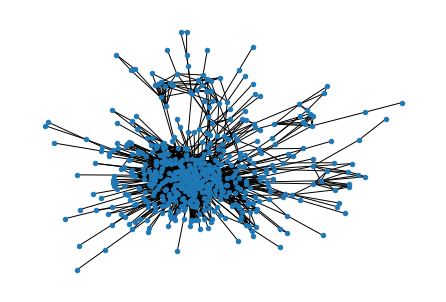

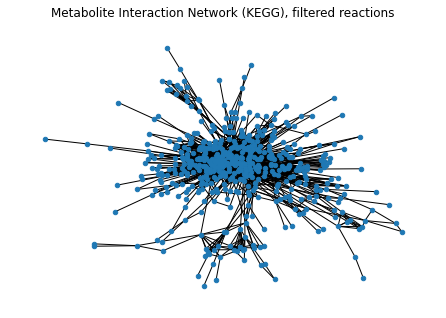

In [67]:
import matplotlib.pyplot as plt
#G=nx.from_pandas_edgelist(mmi_score, "metabolite1", "metabolite2", edge_attr=True)
G_connected = G.subgraph(Gcc[0])
# Plot it
nx.draw(G_connected, with_labels=False, node_size = 20)
plt.show()

# Plot it
pltname="../results/plots/MMI_network_STITCH_700.png"
nx.draw(G_connected, with_labels=False, node_size = 20)
plt.title("Metabolite Interaction Network (STITCH), filtered reactions")
plt.savefig(pltname)
plt.show()


### Degree distribution and node centrality

,count,mean,std,min,25%,50%,75%,max
0,522.0,10.56,15.75,1.0,2.0,5.0,12.0,163.0


522
5512


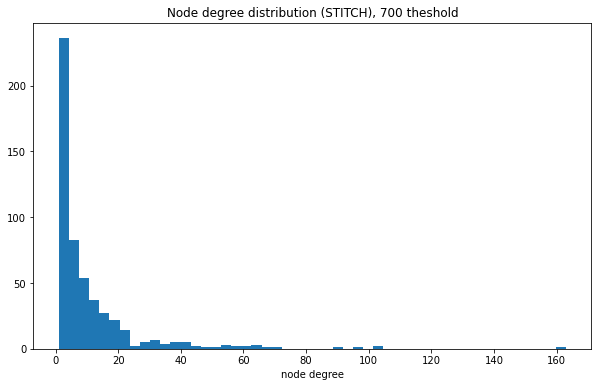

In [68]:
# degree distribution
pltname="../results/plots/Node_degree_STITCH_700.png"
degrees = [val for (node, val) in G_connected.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")

plt.title("Node degree distribution (STITCH), 700 theshold")
plt.savefig(pltname)
plt.show()

threshold 0.15922619047619047


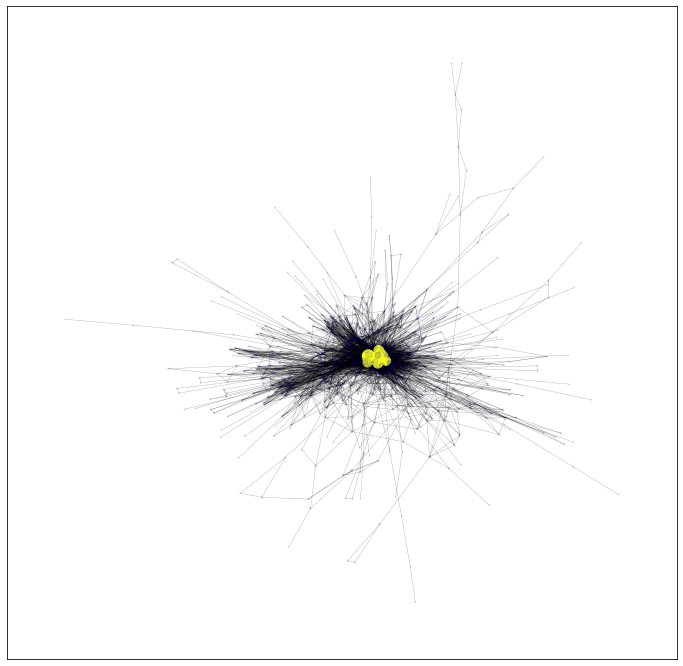

In [53]:
# node centrality

pos = nx.spring_layout(G_connected, seed=42)
cent = nx.degree_centrality(G_connected)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G_connected, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G_connected, pos, width=0.25, alpha=0.5)
plt.show()